# Music classification and generation with spectrograms (GTZAN)

GTZAN dataset which includes audiofiles and spectrograms. You can use this dataset or find your own. The first part of the notebook is all about data visualization and show how to make spectrograms from audiofiles. The second part of the notebook includes a CNN that is trained on the spectrograms to predict music genre.

In [ ]:
!pip install librosa imageio imageio-ffmpeg -q

In [ ]:
import os
import itertools
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
import soundfile as sf
import IPython.display as display
import plotly.graph_objects as go
import librosa
import librosa.display

from collections import OrderedDict
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [ ]:
import tensorflow as tf
tf.__version__

'2.17.1'

In [ ]:
import requests

url = "https://osf.io/drjhb/download"
fname = "music.zip"

if not os.path.isfile(fname):
    r = requests.get(url)
    with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
    zipObj.extractall()

## Have a look at the data

In this section we are looking at an example of an audio waveform. Then we'll transform the sound wave to a spectrogram and compare it with the spectrogram that was included with the downloaded dataset.

In [ ]:
# Inspect an audio file from the dataset.
sample_path = 'Data/genres_original/jazz/jazz.00000.wav'

display.Audio(sample_path)

y: [-0.00924683 -0.01177979 -0.01370239 ...  0.0071106   0.00561523
  0.00561523] 

y shape: (661794,) 

Sample rate (KHz): 22050 

Length of audio: 30.013333333333332


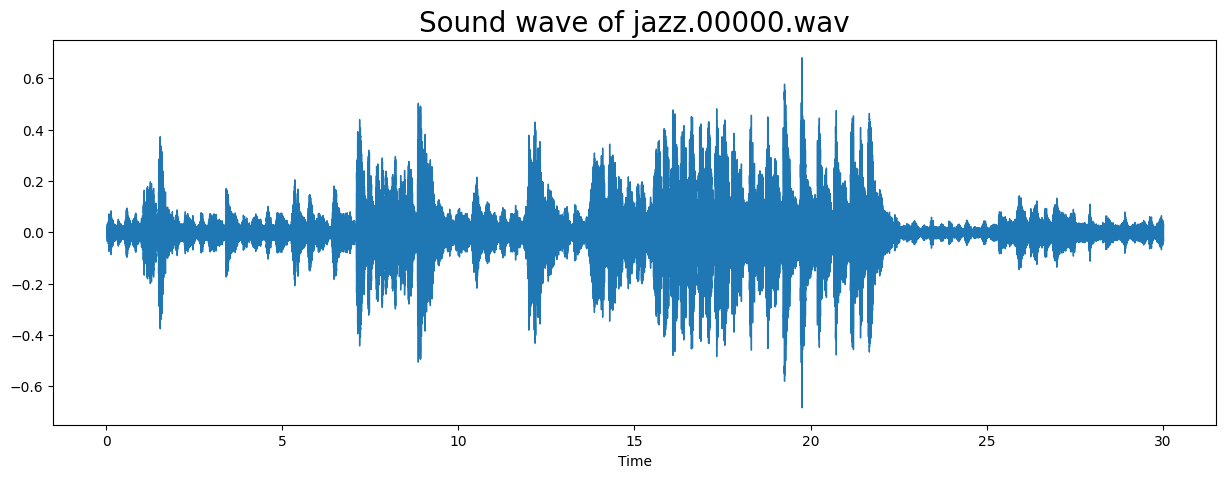

In [ ]:
y, sample_rate = librosa.load(sample_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (KHz):', sample_rate, '\n')
print(f'Length of audio: {np.shape(y)[0]/sample_rate}')

# Plot th sound wave.

plt.figure(figsize=(15, 5))
librosa.display.waveshow(y=y, sr=sample_rate);
plt.title("Sound wave of jazz.00000.wav", fontsize=20)
plt.show()

### Convert sound wave to spectrogram.


Shape of D object: (1025, 1293)


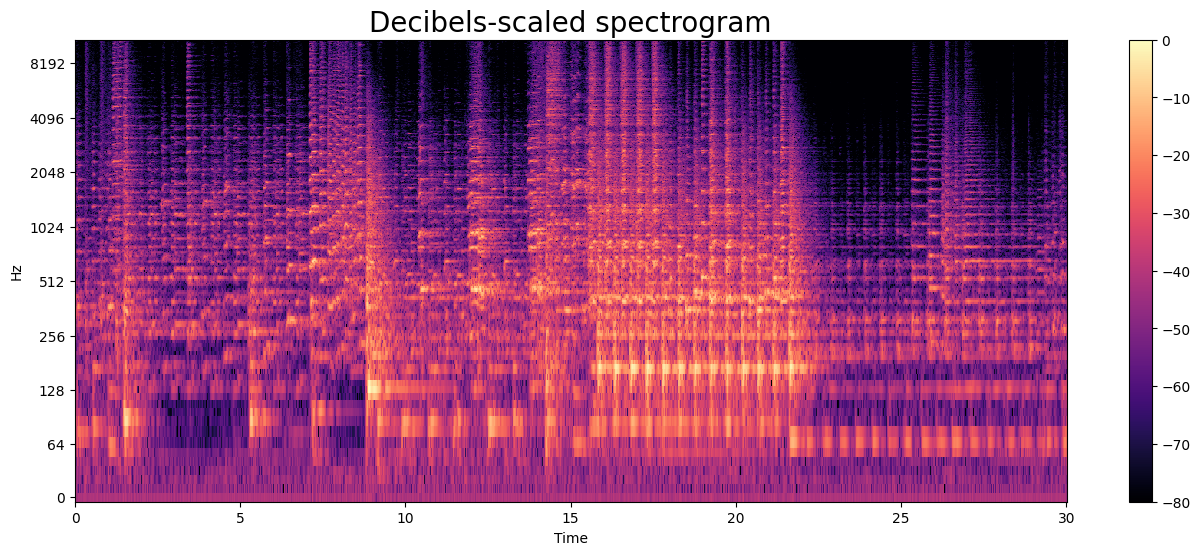

In [ ]:
# Short-time Fourier transform (STFT).
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

In [ ]:
def create_3d_spectrogram(y, sr=22050, n_fft=2048, hop_length=512):
    # Calculate the STFT
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

    # Convert to dB scale
    D_db = librosa.amplitude_to_db(D, ref=np.max)

    # Create time and frequency arrays
    times = librosa.times_like(D, sr=sr, hop_length=hop_length)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Create meshgrid for 3D surface
    time_grid, freq_grid = np.meshgrid(times, freqs)

    # Create the 3D surface plot
    fig = go.Figure(data=[
        go.Surface(
            x=time_grid,
            y=freq_grid,
            z=D_db,
            colorscale='Viridis',
            colorbar=dict(title='Magnitude (dB)')
        )
    ])

    # Update layout
    fig.update_layout(
        title='3D Spectrogram',
        scene=dict(
            xaxis_title='Time (s)',
            yaxis_title='Frequency (Hz)',
            zaxis_title='Magnitude (dB)',
            camera=dict(
                eye=dict(x=1.8, y=1.8, z=1.2),
                up=dict(x=0, y=0, z=1)
            )
        ),
        width=1000,
        height=800
    )

    return fig

fig = create_3d_spectrogram(y, sr=sample_rate)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

The mel spectrogram uses mel sclae intead of a linear one: [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments.

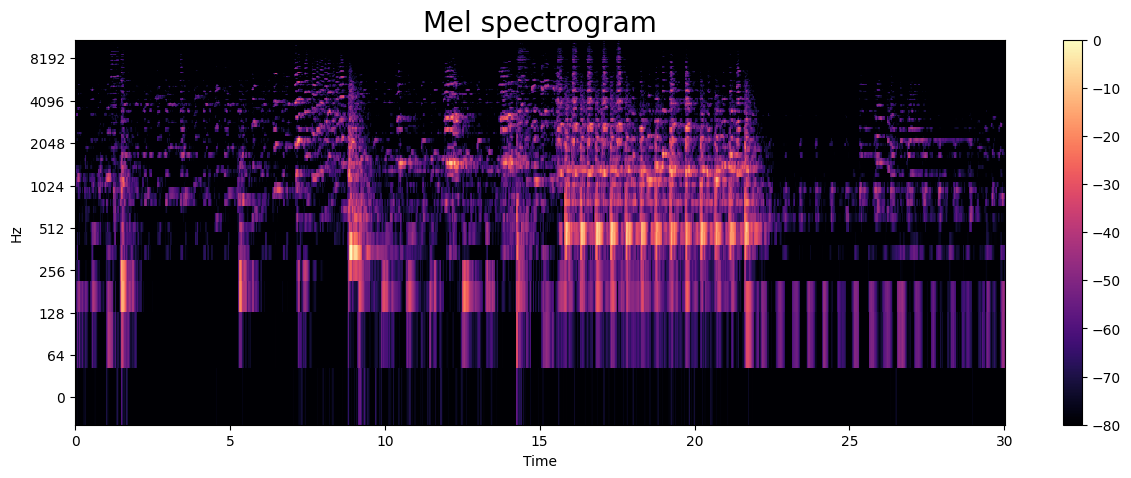

In [ ]:
# Convert sound wave to mel spectrogram.
y, sr = librosa.load(sample_path)

S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.show()

## Process the data

I'll break down this code which appears to be part of an audio processing pipeline, likely for music genre classification.


### 1. `splitsongs(X, y, window, overlap)`
This function splits audio signals into smaller segments:
- Takes a full audio signal and splits it into smaller chunks
- Uses a sliding window approach with configurable window size and overlap
- This is useful because deep learning models often work better with fixed-size inputs, and splitting longer songs allows for more training examples

In [ ]:
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))

    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)


### 2. `to_melspectrogram(songs, n_fft=1024, hop_length=256)`
Converts audio signals into mel spectrograms:
- Uses librosa to transform raw audio into mel spectrogram representations
- Mel spectrograms are visual representations of audio that approximate how human hearing works
- The resulting spectrograms capture frequency and time information in a format suitable for machine learning


In [ ]:
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(y=x.astype(np.float32), n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))


### 3. `load_audio_file(file_path, duration=None)`
A robust audio loading function that tries multiple backends:
- Attempts to load audio files using three different libraries in this order:
  1. scipy.io.wavfile (good for .au files)
  2. soundfile
  3. librosa (as a last resort)
- Handles different audio formats and normalizes the audio data
- Returns the audio signal and sampling rate, or error message if all loading attempts fail


In [ ]:
def load_audio_file(file_path, duration=None):
    """
    Safely load an audio file with multiple backends
    """
    # Try scipy.io.wavfile first (good for .au files)
    try:
        sr, signal = wavfile.read(file_path)
        # Normalize if needed
        if signal.dtype == np.int16:
            signal = signal.astype(np.float32) / 32768.0
        elif signal.dtype == np.int32:
            signal = signal.astype(np.float32) / 2147483648.0
        return signal, sr, None
    except Exception as e1:
        try:
            # Try soundfile next
            signal, sr = sf.read(file_path)
            return signal, sr, None
        except Exception as e2:
            try:
                # Try librosa as last resort
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    signal, sr = librosa.load(file_path, duration=duration)
                    return signal, sr, None
            except Exception as e3:
                return None, None, f"Failed to load audio with all backends"


### 4. `split_convert(X, y, song_samples)`
The main processing pipeline that:
- Takes a list of audio files and their corresponding genres
- Loads each audio file
- Handles various edge cases (mono/stereo, file length)
- Converts the audio to mel spectrograms
- Tracks and reports processing errors
- Returns processed spectrograms and one-hot encoded genre labels


In [ ]:
def split_convert(X, y, song_samples):
    arr_specs, arr_genres = [], []
    errors = []
    successful_files = 0

    # Convert to spectrograms and split into small windows
    print("Processing audio files...")
    for fn, genre in tqdm(zip(X, y), total=len(X)):
        # Check if file exists
        if not os.path.exists(fn):
            errors.append(f"File not found: {fn}")
            continue

        # Load audio file
        signal, sr, error = load_audio_file(fn)
        if error is not None:
            errors.append(f"Error loading {fn}: {error}")
            continue

        # Safety check for signal
        if signal is None or len(signal) == 0:
            errors.append(f"No audio data in {fn}")
            continue

        # Handle mono/stereo
        if len(signal.shape) > 1:
            signal = np.mean(signal, axis=1)

        # Trim to fixed length
        if len(signal) < song_samples:
            errors.append(f"File too short: {fn} ({len(signal)} samples)")
            continue

        signal = signal[:song_samples]

        try:
            # Convert to dataset of spectograms/melspectograms
            signals, y_split = splitsongs(signal, genre)

            # Convert to "spec" representation
            specs = to_melspectrogram(signals)

            # Save files
            arr_genres.extend(y_split)
            arr_specs.extend(specs)
            successful_files += 1

        except Exception as e:
            errors.append(f"Error processing {fn}: {str(e)}")
            continue

    # Print summary of errors
    if errors:
        print("\nProcessing errors:")
        for err in errors[:10]:  # Show first 10 errors
            print(f"- {err}")
        if len(errors) > 10:
            print(f"... and {len(errors) - 10} more errors")

    print(f"\nSuccessfully processed {successful_files} files")

    if not arr_specs:
        raise ValueError("No valid audio files were processed!")

    return np.array(arr_specs), to_categorical(arr_genres)


### 5. `read_data(src_dir, genres, song_samples)`
The top-level function that:
- Scans directories for audio files (.wav, .mp3, .au)
- Organizes files by genre
- Splits data into training and test sets
- Processes both sets using the split_convert function
- Returns processed training and test datasets


In [ ]:
def read_data(src_dir, genres, song_samples):
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    print("Scanning directories...")
    for x, _ in genres.items():
        folder = os.path.join(src_dir, x)  # Use os.path.join for path handling
        if not os.path.exists(folder):
            print(f"Warning: Genre folder not found: {folder}")
            continue

        for root, subdirs, files in os.walk(folder):
            for file in files:
                if file.endswith(('.wav', '.mp3', '.au')):  # Added .au format
                    file_name = os.path.join(folder, file)
                    arr_fn.append(file_name)
                    arr_genres.append(genres[x])

    if not arr_fn:
        raise ValueError(f"No audio files found in {src_dir}")

    print(f"Found {len(arr_fn)} audio files across {len(set(arr_genres))} genres")

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(arr_fn, arr_genres,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=arr_genres,
                                                        )

    # Split into small segments and convert to spectrogram
    print("Processing training set...")
    X_train, y_train = split_convert(X_train, y_train, song_samples)
    print("\nProcessing test set...")
    X_test, y_test = split_convert(X_test, y_test, song_samples)

    return X_train, X_test, y_train, y_test


## Why This Pipeline Matters

This code is designed for music genre classification tasks and addresses several key challenges:

1. **Standardization**: Converts variable-length songs into fixed-size chunks
2. **Feature Extraction**: Transforms raw audio into mel spectrograms, which are more suitable for machine learning
3. **Robustness**: Handles various audio formats and potential errors gracefully
4. **Data Augmentation**: The overlapping windows technique effectively increases the training dataset size
5. **Machine Learning Ready**: Produces standardized inputs suitable for deep learning models

The pipeline is particularly well-suited for deep learning applications in music classification, as it handles the complex task of converting raw audio files into a format that neural networks can effectively process.

In [ ]:
# Parameters
gtzan_dir = 'Data/genres_original/'
song_samples = 660000
genres = {'metal': 0,
          'disco': 1,
          'classical': 2,
          'hiphop': 3,
          'jazz': 4,
          'country': 5,
          'pop': 6,
          'blues': 7,
          'reggae': 8,
          'rock': 9}

# Train test split
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

Scanning directories...
Found 1000 audio files across 10 genres
Processing training set...
Processing audio files...


100%|██████████| 700/700 [03:00<00:00,  3.87it/s]



Successfully processed 700 files

Processing test set...
Processing audio files...


100%|██████████| 300/300 [01:11<00:00,  4.18it/s]


Processing errors:
- Error loading Data/genres_original/jazz/jazz.00054.wav: Failed to load audio with all backends

Successfully processed 299 files


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27300, 128, 129, 1) (11661, 128, 129, 1) (27300, 10) (11661, 10)


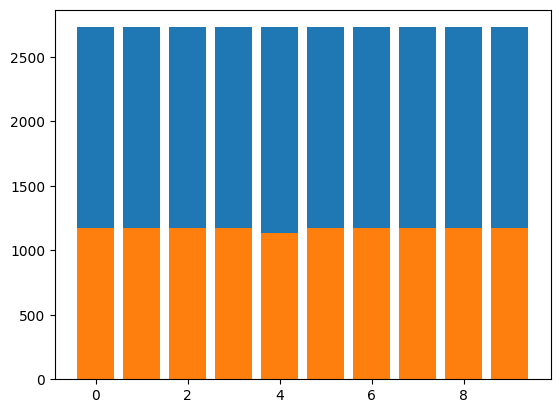

In [ ]:
# Histogram for train and test
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Custom CNN (Melspectrogram version)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

num_classes =  len(genres)

model = Sequential()
# First Convolutional Block
model.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fifth Convolutional Block
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.5))

# Dense layer with L2 regularization
model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.02)))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(num_classes, activation='softmax',kernel_regularizer=l2(0.02)))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'],
              )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 128, 129, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128, 129, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,495,114 (9.52 MB)

 Trainable params: 2,495,114 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

### Loss function

In [ ]:
reduceLROnPlat = ReduceLROnPlateau(
                                    monitor='val_loss',
                                    factor=0.95,
                                    patience=3,
                                    verbose=1,
                                    mode='min',
                                    min_delta=0.0001,
                                    cooldown=2,
                                    min_lr=1e-5
                                    )

In [ ]:
from tensorflow.keras.utils import Sequence
from copy import copy

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test

    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))

    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]

    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)

            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None


In [ ]:
# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
validation_generator = GTZANGenerator(X_test, y_test)

hist = model.fit(
                train_generator,
                validation_data=validation_generator,
                epochs=150,
                verbose=1,
                callbacks=[reduceLROnPlat])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


427/427 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.1365 - loss: 12.4253 - val_accuracy: 0.2025 - val_loss: 2.7455 - learning_rate: 0.0010
Epoch 2/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1763 - loss: 2.6146 - val_accuracy: 0.1378 - val_loss: 2.3777 - learning_rate: 0.0010
Epoch 3/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2129 - loss: 2.2211 - val_accuracy: 0.2230 - val_loss: 2.1862 - learning_rate: 0.0010
Epoch 4/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2044 - loss: 2.1596 - val_accuracy: 0.2563 - val_loss: 2.0308 - learning_rate: 0.0010
Epoch 5/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2289 - loss: 2.0751 - val_accuracy: 0.2521 - val_loss: 2.0190 - learning_rate: 0.0010
Epoch 6/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2408 - loss: 2.0866 - val_accuracy: 0.2914 - val_loss: 1.9272 - learning_rate: 0.0010
Epoch 7/150
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2375 - loss: 2.049

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.022 and val_acc = 0.694


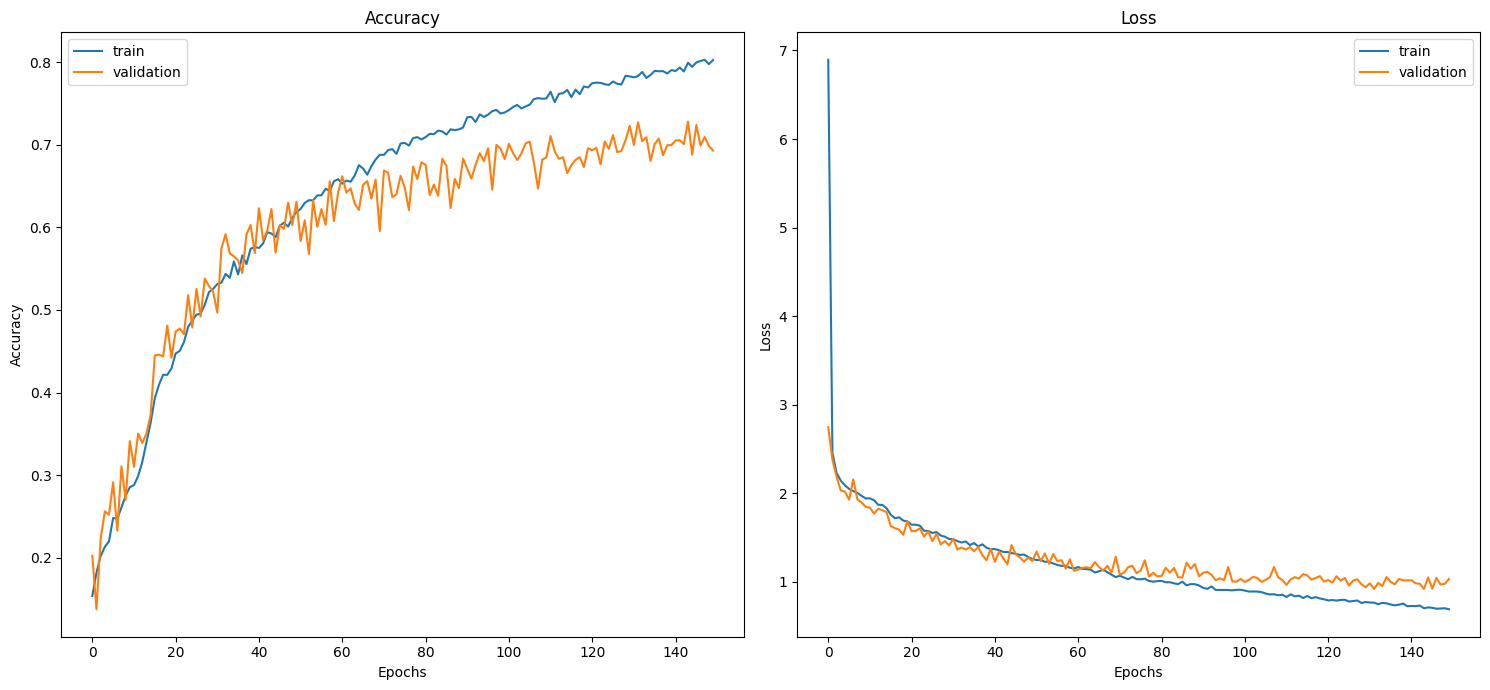

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


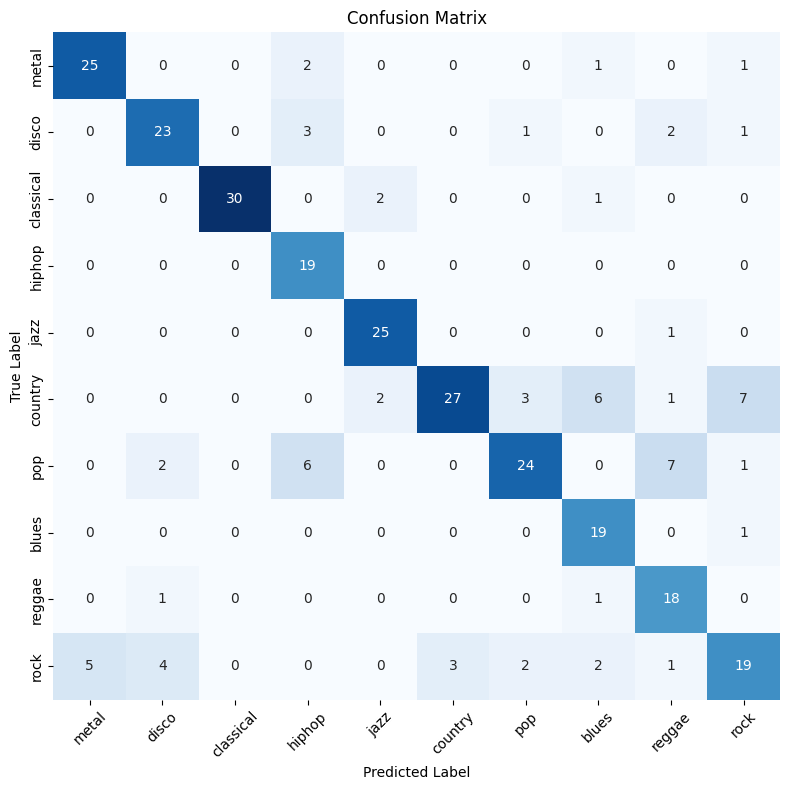


Accuracy per genre:
metal: 86.2%
disco: 76.7%
classical: 90.9%
hiphop: 100.0%
jazz: 96.2%
country: 58.7%
pop: 60.0%
blues: 95.0%
reggae: 90.0%
rock: 52.8%

Total accuracy: 0.0%


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_model(y_pred,y_test, genres, segments_per_song=39):
    # Get predictions per segment
    segment_predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Split into songs
    n_songs = len(segment_predictions) // segments_per_song
    pred_per_song = np.array_split(segment_predictions, n_songs)
    true_per_song = np.array_split(true_labels, n_songs)

    # Get majority vote for each song
    song_predictions = [np.bincount(song).argmax() for song in pred_per_song]
    song_labels = [np.bincount(song).argmax() for song in true_per_song]

    # Calculate confusion matrix
    cm = confusion_matrix(song_labels, song_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    genre_names = list(genres.keys())
    sns.heatmap(cm,#cm_normalized,
                annot=True,
                fmt='.0f',
                cmap='Blues',
                xticklabels=genre_names,
                yticklabels=genre_names,
                cbar=False,
                )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print accuracies
    print(f"\nAccuracy per genre:")
    for genre, idx in genres.items():
        mask = (np.array(song_labels) == idx)
        if np.any(mask):
            acc = np.mean(np.array(song_predictions)[mask] == idx)
            print(f"{genre}: {acc:.1%}")

    # Print total accuracy
    print(f"\nTotal accuracy: {np.mean(song_predictions == song_labels):.1%}")

# Usa il modello
y_pred = model.predict(X_test, batch_size=128, verbose=1)
evaluate_model(y_test, y_pred, genres)

## classification report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Convert one-hot encoded labels back to class indices
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
genre_names = [name for name, idx in sorted(genres.items(), key=lambda x: x[1])]
print(classification_report(y_true_classes, y_pred_classes, target_names=genre_names))

              precision    recall  f1-score   support

       metal       0.76      0.83      0.79      1170
       disco       0.69      0.77      0.72      1170
   classical       0.87      0.97      0.92      1170
      hiphop       0.94      0.56      0.70      1170
        jazz       0.85      0.72      0.78      1131
     country       0.51      0.81      0.62      1170
         pop       0.61      0.81      0.70      1170
       blues       0.87      0.51      0.65      1170
      reggae       0.80      0.53      0.63      1170
        rock       0.42      0.45      0.43      1170

    accuracy                           0.69     11661
   macro avg       0.73      0.69      0.69     11661
weighted avg       0.73      0.69      0.69     11661



## Save the model

In [ ]:
# Save the model
model.save('custom_cnn_2d.keras')